In [1]:
import numpy as np
import pandas as pd
from scipy.stats import binom
from plotly import graph_objects as go
from plotly.graph_objects import Figure
from summer2 import CompartmentalModel
from summer2.parameters import Parameter, Function

In [2]:
# Construct simple model
epimodel = CompartmentalModel(
    [0.0, 100.0],
    ["susceptible", "exposed", "infectious", "recovered"],
    ["infectious"],
)
epimodel.add_infection_frequency_flow(
    "infection",
    Parameter("contact_rate"),
    "susceptible",
    "exposed",
)
epimodel.add_transition_flow(
    "progression",
    Parameter("progression_rate"),
    "exposed",
    "infectious",
)
epimodel.add_transition_flow(
    "recovery",
    Parameter("recovery_rate"),
    "infectious",
    "recovered",
)
init_conds = {"susceptible": Parameter("start_pop") - Parameter("seed"), "infectious": Parameter("seed")}
epimodel.set_initial_population(init_conds)
inc = epimodel.request_output_for_flow("incidence", "progression")
epimodel.request_function_output("notifications", inc * Parameter("cdr"));

In [3]:
# Arbitrary parameters
params = {
    "contact_rate": 0.8,
    "progression_rate": 0.5,
    "recovery_rate": 0.5,
    "cdr": 0.25,
    "start_pop": 1e4,
    "seed": 1.0,
}

In [4]:
# Generate synthetic data for calibration (uses CDR)
epimodel.run(params)
outputs = epimodel.get_derived_outputs_df()
synth_target = outputs[::10]["notifications"].astype(int)

In [16]:
# Try out various contact rate parameters
n_params = 10
contact_rates = np.linspace(0.65, 0.95, n_params)
inc_results = pd.DataFrame(columns=contact_rates)
log_likes = np.zeros(n_params)
for c, contact_param in enumerate(contact_rates):

    # Only get the incidence output from the model, not notifications
    epimodel.run(params | {"contact_rate": contact_param})
    model_result = epimodel.get_derived_outputs_df()
    inc_results[contact_param] = model_result["incidence"]
    model_inc_result = model_result.loc[synth_target.index, "incidence"].astype(int)

    # Likelihood calculation then uses the case detection proportion
    likelihood = binom.pmf(synth_target, model_inc_result, params["cdr"]).prod()
    log_like = zero_like_val if likelihood == 0.0 else np.log(likelihood)
    log_likes[c] = log_like
log_likes[log_likes == 1.0] = log_likes.min() - 10.0
log_likes

array([-147.76547567, -147.76547567, -137.76547567,  -54.32640363,
        -21.23968438,  -20.3929085 ,  -47.08618565, -147.76547567,
       -147.76547567, -147.76547567])

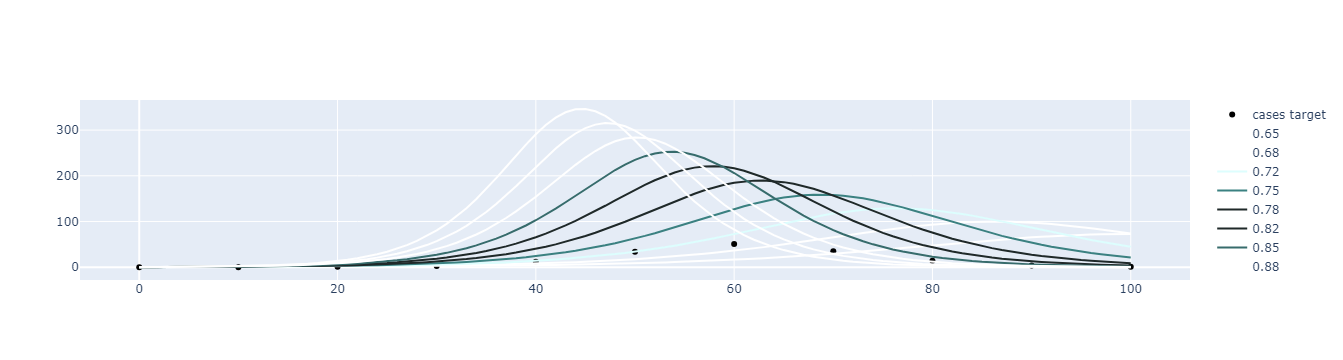

In [17]:
# Illustrate results
fig = Figure()
fig.add_trace(go.Scatter(x=synth_target.index, y=synth_target, name="cases target", mode="markers", line={"color": "black"}))
shades = log_likes / log_likes.min()
for c, contact_param in enumerate(contact_rates):
    shade = round(shades[c] * 100.0)
    fig.add_trace(go.Scatter(x=inc_results[contact_param].index, y=inc_results[contact_param], name=round(contact_param, 2), line={"color": f"hsl(50%,{shade}%,{shade}%)"}))
fig